In [93]:
import pandas

import pygsheets
import numpy
import scipy
import re

import matplotlib
import matplotlib.pyplot as mp
import matplotlib.cm

import textwrap
import seaborn

In [94]:
# solarized colors
solar_base03    = '#002b36' # darkest gray
solar_base02    = '#073642'
solar_base01    = '#586e75'
solar_base00    = '#657b83'
solar_base0     = '#839496' # light gray
solar_base1     = '#93a1a1' # lightest gray
solar_base2     = '#eee8d5' # dark white
solar_base3     = '#fdf6e3' # light white
solar_yellow    = '#b58900'
solar_orange    = '#cb4b16'
solar_red       = '#dc322f'
solar_magenta   = '#d33682'
solar_violet    = '#6c71c4'
solar_blue      = '#268bd2'
solar_cyan      = '#2aa198'
solar_green     = '#859900'

In [95]:
# GEM tracker colors
# done using this: https://imagecolorpicker.com/
#tracker_construction = tracker_red     = '#cb4b16'
#tracker_proposed = tracker_yellow  = '#ffb342'
#tracker_shelved = tracker_blue    = '#609ed0'
#tracker_operating = tracker_brown   = '#976f5d'
#tracker_cancelled = tracker_green   = '#93db92'
#tracker_mothballed = tracker_gray = '#515151'

In [96]:
sel_cmap = matplotlib.cm.get_cmap('Reds')
tracker_operating = sel_cmap(0.999)
tracker_construction = sel_cmap(0.8)
tracker_proposed = sel_cmap(0.6)
tracker_shelved = sel_cmap(0.4)
tracker_cancelled = sel_cmap(0.2)

# pipelines to map

In [97]:
# add ProjectIDs for pipelines discussed in the briefing itself

# import data directly from google sheets

In [98]:
credentials_directory = '/Users/baird/Dropbox/_google-api/'
gc = pygsheets.authorize(client_secret=credentials_directory+'client_secret.json')
spreadsheet = gc.open_by_key('1foPLE6K-uqFlaYgLPAUxzeXfDO5wOOqE7tibNHeqTek')
#spreadsheet = gc.open_by_key('1IQ_g9PCr6pexDvEBoi5jboNfamJtPQ63ezxyq0qRsu0') # specific doc for briefing

#spreadsheet[1] "Gas Pipelines" tab is the second index
gas_pipes = spreadsheet.worksheet('title','Gas pipelines').get_as_df(start='A2')
oil_pipes = spreadsheet.worksheet('title', 'Oil/NGL pipelines').get_as_df(start='A2')

#gas_pipes = gas_pipes.drop('WKTFormat', axis=1) # delete WKTFormat column
#oil_pipes = oil_pipes.drop('WKTFormat', axis=1)

# delete columns that aren't the same in the sheets, to concatenate them...
#columns_not_in_oil = list(set(gas_pipes.columns)-set(oil_pipes.columns))
#columns_not_in_gas = list(set(oil_pipes.columns)-set(gas_pipes.columns))
#gas_pipes.drop(columns=columns_not_in_oil, axis=1, inplace=True)
#oil_pipes.drop(columns=columns_not_in_gas, axis=1, inplace=True)

pipes_df_orig = pandas.concat([oil_pipes, gas_pipes], ignore_index=True)
#pipes_df_orig = pipes_df_orig[pipes_df_orig['Status']!='N/A'] # for container rows
#pipes_df_orig = pipes_df_orig[pipes_df_orig['ProjectID']!=''] # for empty rows at bottom

#get country ratios sheet
country_ratios_df = spreadsheet.worksheet('title', 'Country ratios by pipeline').get_as_df()

In [99]:
owners_df_orig = spreadsheet.worksheet('title', 'Pipeline operators/owners (1/3)').get_as_df(start='A2')
owners_df_orig = owners_df_orig.loc[owners_df_orig.ProjectID!='']
owners_df_orig = owners_df_orig.loc[owners_df_orig.Wiki!='']
owners_df = owners_df_orig.replace('',numpy.nan)

owner_parent_links_df = spreadsheet.worksheet('title', 'Owner–parent relationships (2/3)').get_as_df(start='A2')
# only keep the owners with a checked relationship
owner_parent_links_df = owner_parent_links_df.loc[owner_parent_links_df['Parent–Owner Relationship Checked?']=='yes']
owner_parent_links_df.replace('',numpy.nan,inplace=True)

parents_df = spreadsheet.worksheet('title', 'Parent metadata (3/3)').get_as_df(start='A2')
parents_df = parents_df.loc[parents_df.Parent!='']

owners_df.set_index('ProjectID', inplace=True)
owner_parent_links_df.set_index('Owner', inplace=True)
parents_df.set_index('Parent', inplace=True)

# ****************************************

## create list of owner and parent column names
owner_pct_col_names = []
owner_col_names = []

parent_pct_col_names = []
parent_col_names = []

for num in range(1,11+1):
    owner_pct_col = f'Owner{num}%'
    owner_pct_col_names.append(owner_pct_col)
    
    owner_col = f'Owner{num}'
    owner_col_names.append(owner_col)
    
    parent_pct_col = f'Parent{num}%'
    parent_pct_col_names.append(parent_pct_col)
    
    parent_col = f'Parent{num}'
    parent_col_names.append(parent_col)

# ****************************************
## fill in missing parent info by borrowing owner info
owners_FULL_set = owners_df[owner_col_names].stack().dropna().unique().tolist() # from owners_df
owners_researched_set = list(set(owner_parent_links_df.index.to_list()))#+['Unknown'] # only existing owners, plus 'Unknown'
owners_diff = list(set(owners_FULL_set)-set(owners_researched_set))
owners_diff.append('Unknown')

# update owner_parent_links_df with these extra owners
owner_parent_links_df = pandas.concat([owner_parent_links_df, pandas.DataFrame(index=owners_diff, columns=owner_parent_links_df.columns)])
owner_parent_links_df['Parent1'].loc[owners_diff] = owners_diff
owner_parent_links_df['Parent1%'].loc[owners_diff] = '100.00%'

# ****************************************
# update parents_df with these as well
# note countries will be unknkown...
parents_set = list(set(parents_df.index.to_list()))
parents_diff = list(set(owners_diff)-set(parents_set))
parents_diff.append('Unknown')
parents_df = pandas.concat([parents_df, pandas.DataFrame(numpy.nan, index=parents_diff, columns=parents_df.columns)])
parents_df.loc[parents_diff,'ParentHQCountry'] = 'Unknown'

# for offline excel file

## replace "--" with NaN, removing empty rows

In [37]:
# replace -- entries with NaN
pipes_df_orig = pipes_df_orig.replace('--', numpy.nan)
pipes_df_orig = pipes_df_orig[pipes_df_orig['PipelineName']!='']
pipes_df_orig = pipes_df_orig[pipes_df_orig['Wiki']!='']
country_ratios_df.replace('--', numpy.nan, inplace=True)

In [38]:
# country_ratios_df['StartYearEarliest'].replace('--', numpy.nan, inplace=True)
# country_ratios_df['LengthKnownKm'].replace('--', numpy.nan, inplace=True)
# country_ratios_df['CostUSD'].replace('--', numpy.nan, inplace=True)
# country_ratios_df['CostUSDPerKm'].replace('--', numpy.nan, inplace=True)
# country_ratios_df['LengthKnownKmByCountry'].replace('--', numpy.nan, inplace=True)
# country_ratios_df['Owner'].replace('--', numpy.nan, inplace=True)
# country_ratios_df['Parent'].replace('--', numpy.nan, inplace=True)
# country_ratios_df['CapacityBOEd'].replace('--', numpy.nan, inplace=True)

# km by country, km by region calculations

In [39]:
status_list = ['Proposed', 'Construction', 'Shelved', 'Cancelled', 'Operating', 'Idle', 'Mothballed', 'Retired']
country_list = sorted(list(set(country_ratios_df['Country'])))
region_list = sorted(list(set(country_ratios_df['Region'])))

In [40]:
country_ratios_oil_df = country_ratios_df[country_ratios_df['Fuel']=='Oil']

km_by_country_df = pandas.DataFrame(columns=status_list, index=country_list)
km_by_region_df = pandas.DataFrame(columns=status_list, index=region_list)

print('===country-level calculations===')
for status in status_list:
    print(status)
    country_ratios_oil_df_status = country_ratios_oil_df[country_ratios_oil_df['Status']==status]
    km_by_country_df[status] = country_ratios_oil_df_status.groupby('Country')['MergedKmByCountry'].sum()

print('===regional calculations===')
for status in status_list:
    print(status)
    country_ratios_oil_df_status = country_ratios_oil_df[country_ratios_oil_df['Status']==status]
    km_by_region_df[status] = country_ratios_oil_df_status.groupby('Region')['MergedKmByCountry'].sum()

# # fill NaN with 0.0
km_by_region_df = km_by_region_df.fillna(0)
km_by_country_df = km_by_country_df.fillna(0)

===country-level calculations===
Proposed
Construction
Shelved
Cancelled
Operating
Idle
Mothballed
Retired
===regional calculations===
Proposed
Construction
Shelved
Cancelled
Operating
Idle
Mothballed
Retired


In [41]:
km_by_region_df['Proposed+Construction'] = km_by_region_df[['Proposed','Construction']].sum(axis=1)
km_by_region_df.sort_values(by='Proposed+Construction', inplace=True)
km_by_region_df = km_by_region_df[['Proposed', 'Construction', 'Proposed+Construction', 'Shelved', 'Cancelled', 'Operating', 'Idle', 'Mothballed', 'Retired']]
km_by_region_df.sort_values('Proposed+Construction', ascending=False, inplace=True)

In [42]:
km_by_country_df['Proposed+Construction'] = km_by_country_df[['Proposed','Construction']].sum(axis=1)
km_by_country_df.sort_values(by='Proposed+Construction', inplace=True)
km_by_country_df = km_by_country_df[['Proposed', 'Construction', 'Proposed+Construction', 'Shelved', 'Cancelled', 'Operating', 'Idle', 'Mothballed', 'Retired']]
km_by_country_df.sort_values('Proposed+Construction', ascending=False, inplace=True)

## add Total row to km by country/region

# projects by country, by region

In [43]:
country_ratios_oil_df = country_ratios_df[country_ratios_df['Fuel']=='Oil']

num_by_country_df = pandas.DataFrame(columns=status_list, index=country_list)
num_by_region_df = pandas.DataFrame(columns=status_list, index=region_list)

print('===country-level calculations===')
for status in status_list:
    print(status)
    country_ratios_oil_df_status = country_ratios_oil_df[country_ratios_oil_df['Status']==status]
    num_by_country_df[status] = country_ratios_oil_df_status.groupby('ProjectID')['MergedKmByCountry'].sum()

print('===regional calculations===')
for status in status_list:
    print(status)
    country_ratios_oil_df_status = country_ratios_oil_df[country_ratios_oil_df['Status']==status]
    num_by_region_df[status] = country_ratios_oil_df_status.groupby('Region')['MergedKmByCountry'].sum()

# # fill NaN with 0.0
num_by_region_df = num_by_region_df.fillna(0)
num_by_country_df = num_by_country_df.fillna(0)

===country-level calculations===
Proposed
Construction
Shelved
Cancelled
Operating
Idle
Mothballed
Retired
===regional calculations===
Proposed
Construction
Shelved
Cancelled
Operating
Idle
Mothballed
Retired


In [44]:
km_by_country_df

,Proposed,Construction,Proposed+Construction,Shelved,Cancelled,Operating,Idle,Mothballed,Retired
United States,2913.14,136.75,3049.89,1681.75,24221.22,98015.09,0.0,0.0,1432.00
India,1194.00,1630.00,2824.00,0.00,1338.00,8859.33,0.0,0.0,0.00
China,1046.59,1486.08,2532.67,0.00,8477.06,25271.28,0.0,0.0,6825.55
Russia,1494.20,557.01,2051.21,0.00,541.52,40091.91,0.0,52.0,618.00
Tanzania,1932.31,0.00,1932.31,0.00,0.00,877.39,0.0,0.0,0.00
...,...,...,...,...,...,...,...,...,...
Peru,0.00,0.00,0.00,207.00,0.00,1106.00,0.0,0.0,0.00
Paraguay,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.00
Papua New Guinea,0.00,0.00,0.00,0.00,0.00,265.00,0.0,0.0,0.00
Panama,0.00,0.00,0.00,0.00,0.00,131.00,0.0,0.0,0.00


# numbers of pipes finished in a given year

In [45]:
# count pipelines that are already operating
pipes_started = pipes_df_orig.copy()
pipes_started['StartYearEarliest'].replace(numpy.nan,'',inplace=True)
pipes_started = pipes_started[(pipes_started['Status'].isin(['Operating'])) &
                              (pipes_started['Fuel']=='Oil')]
pipes_started_sum = pipes_started.groupby('StartYearEarliest')['LengthMergedKm'].sum()

In [46]:
# count km of pipeline for each start year
pipes_started_startyear = pipes_df_orig.copy()
pipes_started_startyear['StartYearEarliest'].replace(numpy.nan,'',inplace=True)
pipes_started_startyear = pipes_started_startyear[(pipes_started_startyear['Status'].isin(['Operating'])) &
                              (pipes_started_startyear['Fuel']=='Oil')]
#pipes_started_startyear_sum = pipes_started_startyear.groupby('StartYearLatest')['LengthMergedKm'].sum()

In [47]:
# indev pipelines = Proposed or Construction
pipes_indev = pipes_df_orig.copy()
pipes_indev = pipes_indev[pipes_indev['Fuel']=='Oil']
pipes_indev = pipes_indev.groupby('Status')['LengthMergedKm'].sum()

In [48]:
pipes_indev_to2030 = pipes_df_orig.copy()
pipes_indev_to2030 = pipes_indev_to2030[(pipes_indev_to2030['Fuel']=='Oil') &
                                        (pipes_indev_to2030['Status'].isin(['Proposed','Construction','Shelved'])) &
                                        (pipes_indev_to2030['StartYearEarliest'].isin(list(range(2023,2031))))]
pipes_indev_to2030 = pipes_indev_to2030.groupby('Status')['LengthMergedKm'].sum()

In [49]:
pipes_indev_startyear = pipes_df_orig.copy()
pipes_indev_startyear = pipes_indev_startyear[(pipes_indev_startyear['Status'].isin(['Proposed','Construction','Shelved'])) &
                                              (pipes_indev_startyear['Fuel']=='Oil')]
pipes_indev_startyear = pipes_indev_startyear.groupby(['Status','StartYearEarliest'])['LengthMergedKm'].sum()

## Fig 2 again - 2023–2030, go back to 2008

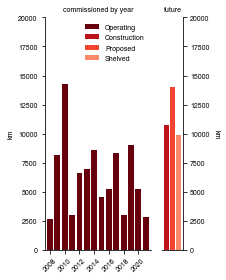

In [50]:
font_size = 7

ytop = 20000
ytop2 = 20000

fig = mp.figure(figsize=(3.25,4))

widths=[15,3]
spec = fig.add_gridspec(ncols=2, nrows=1, width_ratios=widths)

ax = fig.add_subplot(spec[0,0])

#axpos = ax.get_position()
ax.bar(pipes_started_sum.index.values[-15:-1], pipes_started_sum.values[-15:-1],
       color=tracker_operating, label='Operating') # color=solar_base03
ax.tick_params(labelsize=font_size)
ax.tick_params('x', rotation=45)
#ax.set_xlabel('start year', size=font_size)
ax.set_ylabel('km', size=font_size)

ax.set_xlim(2007.25, 2021.75)
ax.set_ylim(0, ytop)

ax.xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))

ax2 = fig.add_subplot(spec[0,1])
ax2.set_ylim(0, ytop2)
ax2.set_xlim(0.25,3.75)
#ax2pos = ax2.get_position()
xvals = [1,2,3]

#colors = [solar_orange, solar_yellow, '0.75']
colors = [tracker_construction, tracker_proposed, tracker_shelved]
status = ['Construction', 'Proposed', 'Shelved']
ax2_list = []
for x,c,s in zip(xvals,colors,status):
    ax2_list.append(ax2.bar(x, pipes_indev[s],
             color=c, label=s))

ax_h, ax_l = ax.get_legend_handles_labels()
ax2_h, ax2_l = ax2.get_legend_handles_labels()

#ax2.set_xlabel('possible\nfuture', size=font_size)
#ax2.set_yticklabels([])
ax2.set_xticklabels([])
ax2.tick_params(labelsize=font_size)
ax2.set_xticks([])

ax2.yaxis.tick_right()
ax2.set_ylabel('km', fontsize=font_size, rotation=-90, labelpad=10)
ax2.yaxis.set_label_position('right')
#ax2.set_yticklabels([])
#ax2.set_yticks([])

ax.legend(handles=ax_h+ax2_h, fontsize=font_size, frameon=False)

axpos = ax.get_position()
ax2pos = ax2.get_position()

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax2.spines['left'].set_visible(False)
ax2.spines['top'].set_visible(False)
#ax2.spines['right'].set_visible(False)

ax.set_title('commissioned by year', fontsize=font_size)
ax2.set_title('future', fontsize=font_size)

fig.tight_layout()#w_pad=0.05)
#fig.subplots_adjust(wspace=0.05, hspace=None)

mp.savefig('saved-figures/oil-pipelines_km-by-start-year-backto2008.png', bbox_inches='tight', transparent=True, dpi=600)
mp.savefig('saved-figures/oil-pipelines_km-by-start-year-backto2008.pdf', bbox_inches='tight', transparent=True)

## plus/minus 8 years

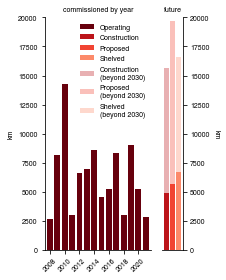

In [51]:
font_size = 7

ytop = 20000
ytop2 = 20000

fig = mp.figure(figsize=(3.25,4))

widths=[15,3]
spec = fig.add_gridspec(ncols=2, nrows=1, width_ratios=widths)

ax = fig.add_subplot(spec[0,0])

#axpos = ax.get_position()
ax.bar(pipes_started_sum.index.values[-15:-1], pipes_started_sum.values[-15:-1],
       color=tracker_operating, label='Operating') # color=solar_base03
ax.tick_params(labelsize=font_size)
ax.tick_params('x', rotation=45)
#ax.set_xlabel('start year', size=font_size)
ax.set_ylabel('km', size=font_size)

ax.set_xlim(2007.25, 2021.75)
ax.set_ylim(0, ytop)

ax.xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))

ax2 = fig.add_subplot(spec[0,1])
ax2.set_ylim(0, ytop2)
ax2.set_xlim(0.25,3.75)
#ax2pos = ax2.get_position()
xvals = [1,2,3]

#colors = [solar_orange, solar_yellow, '0.75']
colors = [tracker_construction, tracker_proposed, tracker_shelved]
status = ['Construction', 'Proposed', 'Shelved']
status_alt = ['Construction\n(beyond 2030)', 'Proposed\n(beyond 2030)', 'Shelved\n(beyond 2030)']
ax2_list = []

for x,c,s in zip(xvals,colors,status):
    ax2_list.append(ax2.bar(x, pipes_indev_to2030[s],
             color=c, label=s))

for x,c,s,s_alt in zip(xvals,colors,status,status_alt):
    ax2_list.append(ax2.bar(x, pipes_indev[s], bottom=pipes_indev_to2030[s],
             color=c, label=s_alt, alpha=0.333))

ax_h, ax_l = ax.get_legend_handles_labels()
ax2_h, ax2_l = ax2.get_legend_handles_labels()

#ax2.set_xlabel('possible\nfuture', size=font_size)
#ax2.set_yticklabels([])
ax2.set_xticklabels([])
ax2.tick_params(labelsize=font_size)
ax2.set_xticks([])

ax2.yaxis.tick_right()
ax2.set_ylabel('km', fontsize=font_size, rotation=-90, labelpad=10)
ax2.yaxis.set_label_position('right')
#ax2.set_yticklabels([])
#ax2.set_yticks([])

ax.legend(handles=ax_h+ax2_h, fontsize=font_size, frameon=False)

axpos = ax.get_position()
ax2pos = ax2.get_position()

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax2.spines['left'].set_visible(False)
ax2.spines['top'].set_visible(False)
#ax2.spines['right'].set_visible(False)

ax.set_title('commissioned by year', fontsize=font_size)
ax2.set_title('future', fontsize=font_size)

fig.tight_layout()#w_pad=0.05)
#fig.subplots_adjust(wspace=0.05, hspace=None)

#mp.savefig('saved-figures/oil-pipelines_km-by-start-year-plusminus-8yrs.png', bbox_inches='tight', transparent=True, dpi=600)
#mp.savefig('saved-figures/oil-pipelines_km-by-start-year-plusminus-8yrs.pdf', bbox_inches='tight', transparent=True)

## percent pipelines with start date (sanity check)

In [52]:
pipes_scratch = pipes_df_orig.copy()
pipes_scratch = pipes_scratch[(pipes_scratch['Fuel']=='Oil') &
                              (pipes_scratch['Status'].isin(['Proposed','Construction','Shelved']))]

In [53]:
pipes_scratch[~pipes_scratch['StartYearEarliest'].isnull()]['StartYearEarliest'].count()/pipes_scratch.shape[0]


0.6037735849056604

## regional pipelines started in given year

In [54]:
years_array = numpy.arange( float(pipes_df_orig['StartYearEarliest'].min()), float(pipes_df_orig['StartYearEarliest'].max())+1)
regions_startyear_sums_df = pandas.DataFrame(numpy.nan, index=years_array, columns=region_list)

In [55]:
#pipes_started = pipes_df.copy()[(pipes_df['Status'].isin(['Operating'])) & pipes_df['Fuel']=='Gas']
#pipes_started_sum = pipes_started.groupby('StartYearLatest')['LengthMergedKm'].sum()

for region in region_list:
    pipes_started = pipes_df_orig.copy()[(pipes_df_orig['Status'].isin(['Operating','Retired','Idle'])) & 
                                    (pipes_df_orig['Fuel']=='Oil')]
    pipes_started = pipes_started[pipes_started['StartRegion']==region]
    pipes_started_sum_up = pipes_started.groupby('StartYearEarliest')['LengthMergedKm'].sum()
    
    regions_startyear_sums_df[region] = pipes_started_sum_up

In [56]:
if len(region_list)!=10:
    region_list = region_list[2:]

## plot pie chart of regional values

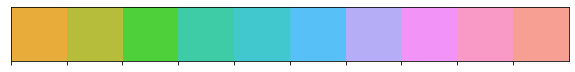

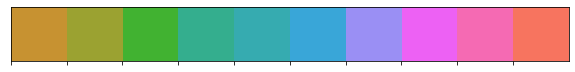

In [57]:
# mess with some color pallettes
#seaborn.color_palette('husl', 10)
seaborn.palplot(seaborn.husl_palette(10, s=0.9, l=0.75, h=0.15))
seaborn.palplot(seaborn.husl_palette(10, h=0.15))

cmap_dark = seaborn.husl_palette(10, h=0.15, l=0.4, s=0.8, as_cmap=True)
cmap_light = seaborn.husl_palette(10, h=0.15, s=1, as_cmap=True)

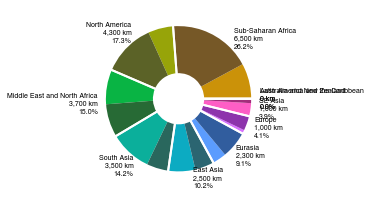

In [58]:
font_size=7

fig = mp.figure(figsize=(5,5))
ax = fig.add_subplot(111)

nwedges = region_list.__len__()
region_order = km_by_region_df.index[:nwedges]

pie_vals = km_by_region_df.loc[region_order]['Proposed+Construction'].values
pie_labels = km_by_region_df.index
pie_labels_km = km_by_region_df.loc[region_order]['Proposed+Construction'].apply(lambda x: f'\n{int(round(x,-2)):,} km')
pie_labels_perc = (km_by_region_df.loc[region_order]['Proposed+Construction'] / 
                   km_by_region_df.loc[region_order]['Proposed+Construction'].sum() * 100.).apply(lambda x: f'\n{x:.1f}%')

# ****************************************
pie_vals_separated = km_by_region_df.loc[region_order][['Construction','Proposed']].values.flatten()
#pie_labels_separated = numpy.array(list(zip(km_by_region_df.index[:-1],km_by_region_df.index[:-1]))).flatten()
#pie_labels_km = km_by_region_df.loc[region_order]['Proposed+Construction'].apply(lambda x: f'\n{int(round(x,-3)):,} km')

nwedges_separated = 20
cmap_light_10 = cmap_light(numpy.linspace(0,1,nwedges))
cmap_dark_10 = cmap_dark(numpy.linspace(0,1,nwedges))

pie_labels = [i+j+k for i,j,k in zip(pie_labels, pie_labels_km, pie_labels_perc)]
pie_width = 0.666

# ****************************************
# size=0.3
ax.pie(pie_vals_separated, 
       #labels=pie_labels,
       #radius=1-size,
       colors=numpy.hstack((cmap_light_10, cmap_dark_10)).reshape(20,-1),
       wedgeprops=dict(width=pie_width),
       textprops={'fontsize': font_size})
ax.pie(pie_vals, 
       labels=pie_labels,
       #radius=1,
       #bottom=0.25,
       colors=None,#cmap(numpy.linspace(0,1,pie_vals.size))[::-1],
       wedgeprops=dict(edgecolor='1', facecolor='None', linewidth=2, width=pie_width),
       textprops={'fontsize': font_size})


ax.tick_params(labelsize=font_size)

fig.tight_layout()

mp.savefig('saved-figures/oil-pipelines_pie-graph-country-pipelines-km.pdf', bbox_inches='tight', transparent=True)

#mp.savefig('saved-figures/oil-pipelines_pie-graph-country-pipelines-km.png', 
#           bbox_inches='tight', 
#           transparent=True,
#           dpi=600)

# top 20 countries proposed+construction

In [59]:
def adjust_spines(ax, spines):
    for loc, spine in ax.spines.items():
        if loc in spines:
            spine.set_position(('outward', 10))  # outward by 10 points
        else:
            spine.set_color('none')  # don't draw spine

    # turn off ticks where there is no spine
    if 'left' in spines:
        ax.yaxis.set_ticks_position('left')
    else:
        # no yaxis ticks
        ax.yaxis.set_ticks([])

    if 'bottom' in spines:
        ax.xaxis.set_ticks_position('bottom')
    else:
        # no xaxis ticks
        ax.xaxis.set_ticks([])

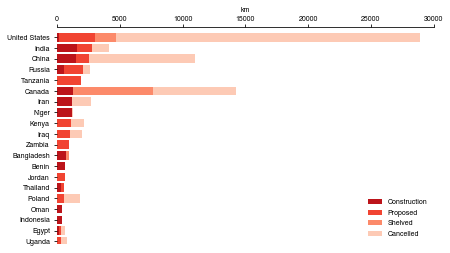

In [60]:
font_size = 7
fig = mp.figure(figsize=(6.75,4))
nbars=20

country_order = km_by_country_df.index[:nbars][::-1]

ax = fig.add_subplot(111)

ax.barh(numpy.arange(nbars), 
        km_by_country_df.loc[country_order]['Construction'].values, 
        facecolor=tracker_construction,#solar_orange, 
        label='Construction')

ax.barh(numpy.arange(nbars), 
        km_by_country_df.loc[country_order]['Proposed'].values, 
        left=km_by_country_df.loc[country_order]['Construction'].values, 
        facecolor=tracker_proposed,#solar_yellow, 
        label='Proposed')

ax.barh(numpy.arange(nbars), 
        km_by_country_df.loc[country_order]['Shelved'].values, 
        left=km_by_country_df.loc[country_order][['Proposed','Construction']].sum(axis=1).values, 
        facecolor=tracker_shelved,#'0.75', 
        label='Shelved')

ax.barh(numpy.arange(nbars), 
        km_by_country_df.loc[country_order]['Cancelled'].values, 
        left=km_by_country_df.loc[country_order][['Proposed','Construction','Shelved']].sum(axis=1).values, 
        facecolor=tracker_cancelled,#'0.9', 
        label='Cancelled')

ax.set_yticks(numpy.arange(nbars))
ax.set_yticklabels(km_by_country_df.index[:nbars][::-1])
ax.tick_params(labelsize=font_size)
ax.tick_params('x', pad=0)
ax.set_xlim(0,30000)
#ax.set_ylim(-.75,19.75)
ax.set_ylim(-.25,20)
ax.set_xlabel('km', size=font_size)#, labelpad=10)
ax.xaxis.set_ticks_position('top')
ax.xaxis.set_label_position('top')

ax.legend(fontsize=font_size, frameon=False, loc='lower right')

ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

#mp.savefig('saved-figures/oil-pipelines_top-20-countries.pdf', bbox_inches='tight', transparent=True)

#adjust_spines(ax, ['top'])
    
mp.savefig('saved-figures/oil-pipelines_top-20-countries.png',
          bbox_inches='tight', 
          transparent=True,
          dpi=600)

mp.savefig('saved-figures/oil-pipelines_top-20-countries.pdf',
          bbox_inches='tight', 
          transparent=True)

# top 20 without cancelled and shelved bars

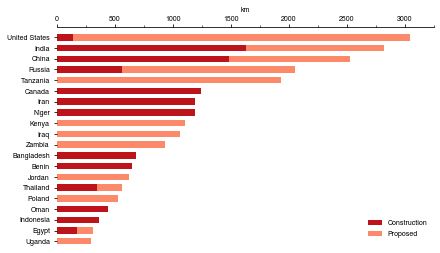

In [61]:
sel_cmap = matplotlib.cm.get_cmap('Reds')
#tracker_operating = sel_cmap(0.999)
#tracker_construction = sel_cmap(0.8)
#tracker_proposed = sel_cmap(0.6)
#tracker_shelved = sel_cmap(0.4)
#tracker_cancelled = sel_cmap(0.2)

font_size = 7
fig = mp.figure(figsize=(6.75,4))
nbars=20

country_order = km_by_country_df.index[:nbars][::-1]

ax = fig.add_subplot(111)

ax.barh(numpy.arange(nbars), 
        km_by_country_df.loc[country_order]['Construction'].values, 
        facecolor=sel_cmap(0.8),
        label='Construction', height=0.6)

ax.barh(numpy.arange(nbars), 
        km_by_country_df.loc[country_order]['Proposed'].values, 
        left=km_by_country_df.loc[country_order]['Construction'].values, 
        facecolor=sel_cmap(0.4),
        label='Proposed', height=0.6)

ax.set_yticks(numpy.arange(nbars))
ax.set_yticklabels(km_by_country_df.index[:nbars][::-1])
ax.tick_params(labelsize=font_size)
ax.tick_params('x', pad=0)
ax.set_xlim(0,3250)
#ax.set_ylim(-.75,19.75)
ax.set_ylim(-.25,20)
ax.set_xlabel('km', size=font_size)#, labelpad=10)
ax.xaxis.set_ticks_position('top')
ax.xaxis.set_label_position('top')

ax.legend(fontsize=font_size, frameon=False, loc='lower right')

ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

#ax.xaxis.grid(True, which='minor')
ax.xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(2))


#mp.savefig('saved-figures/oil-pipelines_top-20-countries.pdf', bbox_inches='tight', transparent=True)

#adjust_spines(ax, ['top'])
    
mp.savefig('saved-figures/oil-pipelines_top-20-countries-no-cancelled-shelved.png',
          bbox_inches='tight', 
          transparent=True,
          dpi=600)

mp.savefig('saved-figures/oil-pipelines_top-20-countries-no-cancelled-shelved.pdf',
          bbox_inches='tight', 
          transparent=True)

In [62]:
# ratio of China to India (how many times larger is km of Chinese pipelines than India?)
km_by_country_df.loc['China']['Proposed+Construction']/km_by_country_df.loc['India']['Proposed+Construction']

0.8968378186968838

# parent analysis

In [91]:
owner_parent_calculations_df = pandas.DataFrame()
# needs country, km in each country columns as well

for idx,row in pipes_df_orig.loc[pipes_df_orig.Fuel=='Oil'].iterrows():
    parent_string = row.Parent
    parent_list = re.sub(' \[.*?\]', '', parent_string).split('; ') # all entries must have a Owner [%] syntax
    percent_list = [float(i.rstrip('%'))/100. for i in re.findall('\\d+(?:\\.\\d+)?%', parent_string)]

    if parent_list.__len__()!=percent_list.__len__():
        if percent_list==[]:
            percent_list = [1/parent_list.__len__() for i in parent_list]
        else:
            nmissing = parent_list.__len__()-percent_list.__len__()
            # distribute nans evenly
            total = numpy.nansum(percent_list)
            leftover = 1-total
            percent_list += [leftover/nmissing]*nmissing

    for p_idx,parent in enumerate(parent_list):
        owner_parent_calculations_df = pandas.concat([owner_parent_calculations_df, 
                                                      pandas.DataFrame([{'Parent':parent, 'ProjectID':row.ProjectID, 
                                                                         'FractionOwnership':percent_list[p_idx],
                                                                         'Country':parents_df.loc[parents_df.index==parent]['ParentHQCountry'].values[0],
                                                                         'Status':row.Status,
                                                                         'LengthMergedKm':row.LengthMergedKm,
                                                                         'CapacityBOEd':row.CapacityBOEd}])])

owner_parent_calculations_df['KmOwnership'] = owner_parent_calculations_df.FractionOwnership*owner_parent_calculations_df.LengthMergedKm
owner_parent_calculations_df['CapacityOwnership'] = owner_parent_calculations_df.FractionOwnership*owner_parent_calculations_df.CapacityBOEd

IndexError: index 0 is out of bounds for axis 0 with size 0

In [92]:
parent

'KazMunayGas'

### companies invested in Russian infrastructure?

it's really just ProjectIDs 2044 (Caspian Oil Pipeline), 3675 (Vostok Oil Pipeline), and 3679 (Sabo-Dagi Oil Pipeline)

In [ ]:
# project IDs of pipelines that pass through Russia and are construction/proposed
russian_indev_projectids = country_ratios_oil_df.loc[(country_ratios_oil_df.Status.isin(['Proposed','Construction']))&
                                                     (country_ratios_oil_df.Country=='Russia')]['ProjectID'].unique()
#russian_indev_projectids
russian_indev_op_df = owner_parent_calculations_df.loc[owner_parent_calculations_df.ProjectID.isin(russian_indev_projectids)]
russian_indev_op_df.loc[russian_indev_op_df.Country!='Russia']

## biggest parent companies for in-dev stuff?

In [ ]:
pandas.DataFrame(
    owner_parent_calculations_df.loc[
        owner_parent_calculations_df.Status.isin(['Proposed','Construction','Country'])].groupby(
        'Parent')['KmOwnership'].sum()).sort_values('KmOwnership', ascending=False)[:20]

In [ ]:
pandas.DataFrame(
    owner_parent_calculations_df.loc[
        owner_parent_calculations_df.Status.isin(['Proposed','Construction'])].groupby(
        ['Parent','Country'])[['KmOwnership','CapacityOwnership']].sum(min_count=1)).sort_values('KmOwnership', ascending=False)[:20]

### how many of the projects for each owner do we have capacity data for? (add fraction)

### also calculate emissions estimates

In [ ]:
# kuhne paper
co2_rate = 152.789 # number is 152,789 tCO2/year emissions per kilobarrel per day, divide by 1000 to get per bpd (bpd=BOEd)

In [ ]:
x

In [ ]:
# calculate the number of CapacityBOEd entries, and which of those are NaNs
# https://stackoverflow.com/questions/14529838/apply-multiple-functions-to-multiple-groupby-columns
pandas.set_option('display.max_colwidth', None)
result = owner_parent_calculations_df.loc[
    owner_parent_calculations_df.Status.isin(['Proposed','Construction'])].groupby(
    ['Parent','Country'])[['KmOwnership','CapacityBOEd','ProjectID']].agg({'KmOwnership':lambda x: x.sum(min_count=1),
                                                                           'CapacityBOEd':[lambda x: x.sum(min_count=1),
                                                                                           lambda x: x.dropna().count()],
                                                                           'ProjectID':[lambda x: list(x.unique()).__len__(),
                                                                                        lambda x: list(x.unique()),
                                                                                        lambda x: [pipes_df_orig.loc[pipes_df_orig.ProjectID==i]['PipelineName'] for i in x]
                                                                                                  ]})

result['HowManyProjectsHaveCapacityData'] = result[('CapacityBOEd','<lambda_1>')].astype(str) + ' of ' + result[('ProjectID','<lambda_0>')].astype(str)
result[['KmOwnership','CapacityBOEd','HowManyProjectsHaveCapacityData']].sort_values(('KmOwnership','<lambda>'), ascending=False)[:20]
result['EmissionsMtCO2PerYear'] = result[('CapacityBOEd','<lambda_0>')]*co2_rate/1e6

In [ ]:
result[[('KmOwnership','<lambda>'),
        ('CapacityBOEd','<lambda_0>'),
        ('EmissionsMtCO2PerYear',''),
        ('HowManyProjectsHaveCapacityData',''),
        ('ProjectID','<lambda_1>'),
        ('ProjectID','<lambda_2>')]].sort_values(('KmOwnership','<lambda>'), ascending=False)[:20]

### total emissions globally (known capacity is at about 67%)

In [ ]:
pipes_df_subset = pipes_df_orig.loc[(pipes_df_orig.Status.isin(['Construction','Proposed']))&
                                     (pipes_df_orig.Fuel=='Oil')]
print(pipes_df_subset['CapacityBcm/y'].dropna().size / pipes_df_subset['CapacityBcm/y'].size)
pipes_df_subset['CapacityBOEd'].sum() * co2_rate / 1e6

In [ ]:
pipes_df_subset = pipes_df_orig.loc[(pipes_df_orig.Status.isin(['Proposed']))&
                                     (pipes_df_orig.Fuel=='Oil')]
print(pipes_df_subset['CapacityBcm/y'].dropna().size / pipes_df_subset['CapacityBcm/y'].size)
pipes_df_subset['CapacityBOEd'].sum() * co2_rate / 1e6

In [ ]:
pipes_df_subset = pipes_df_orig.loc[(pipes_df_orig.Status.isin(['Construction']))&
                                     (pipes_df_orig.Fuel=='Oil')]
print(pipes_df_subset['CapacityBcm/y'].dropna().size / pipes_df_subset['CapacityBcm/y'].size)
pipes_df_subset['CapacityBOEd'].sum() * co2_rate / 1e6

### diameter analysis

to see if it's useful to estimate missing capacities from diameter

looks like this could be possible using a log-linear plot (below), though this would only buy us an additional 15 data points, which isn't worth it to me

In [ ]:
pipes_df_fix_diam = pipes_df_orig.copy()
for idx,row in pipes_df_fix_diam.iterrows():
    diameter_vals = row.Diameter
    if type(diameter_vals)==str and ',' in diameter_vals:
        #print(row.PipelineName)
        diameter_list = [i.strip() for i in diameter_vals.split(',')]
        diameter_list = [float(i) for i in diameter_list]
        max_diam = max(diameter_list)
        pipes_df_fix_diam.loc[idx,'Diameter'] = max_diam
        #print(max_diam)
        if row.DiameterUnits=='in':
            pipes_df_fix_diam.loc[idx,'DiameterInMm'] = max_diam*25.4
pipes_df_fix_diam['DiameterInMm'].replace('--',numpy.nan,inplace=True)

In [ ]:
mp.scatter(pipes_df_fix_diam.DiameterInMm, pipes_df_fix_diam.CapacityBOEd)
mp.yscale('log')
#mp.xlim(0,0.1)

### how many could you add by extrapolating capacity?

it's about 15, not really enough to do that, I think

In [ ]:
pipes_df_subset = pipes_df_fix_diam.loc[(pipes_df_orig.Status.isin(['Construction','Proposed','Shelved']))&
                                     (pipes_df_orig.Fuel=='Oil')]
pipes_df_subset.loc[(pipes_df_subset['CapacityBOEd'].isna())&
                    (~pipes_df_subset['DiameterInMm'].isna())]['DiameterInMm'].count()

that would take it up to about 84% capacity info

In [ ]:
pipes_df_subset = pipes_df_orig.loc[(pipes_df_orig.Status.isin(['Construction','Proposed','Shelved']))&
                                     (pipes_df_orig.Fuel=='Oil')]
(pipes_df_subset['CapacityBcm/y'].dropna().size + 15) / pipes_df_subset['CapacityBcm/y'].size

### count fraction of available capacity information

count

In [ ]:
pipes_df_subset = pipes_df_orig.loc[(pipes_df_orig.Status.isin(['Construction','Proposed']))&
                                     (pipes_df_orig.Fuel=='Gas')]
pipes_df_subset.loc[~pipes_df_subset['CapacityBcm/y'].isna()].groupby('StartRegion')['CapacityBOEd'].size()
#pipes_df_subset.groupby('StartRegion')['CapacityBcm/y'].size()

fraction

In [ ]:
pipes_df_subset.loc[~pipes_df_subset['CapacityBcm/y'].isna()].groupby('StartRegion')['CapacityBcm/y'].size()/pipes_df_subset.groupby('StartRegion')['CapacityBOEd'].size()

In [ ]:
median_capacity = pipes_df_orig['CapacityBcm/y'].median()

In [ ]:
abs_dist_from_med_capacity = abs(pipes_df_orig['CapacityBcm/y']-pipes_df_orig['CapacityBcm/y'].median()).median()

In [ ]:
pipes_df_orig['CapacityBcm/y'].mean()

In [ ]:
pipes_df_orig['CapacityBcm/y'].std()

In [ ]:
print(median_capacity)
print(abs_dist_from_med_capacity)

In [ ]:
# median capacity for a pipeline is about 10.56 bcm/y
# median abs dist from the median is about 9.96

# cost estimates (pipeline cost per km)

## looking for cost outliers

In [ ]:
# pull out only pipelines that have a KNOWN length AND a cost
country_ratios_with_length_and_cost_df = country_ratios_df.copy()[(country_ratios_df['Fuel']=='Oil') & 
                                    (country_ratios_df['CostUSDPerKm'].notna()) & 
                                    (country_ratios_df['LengthKnownKmByCountry'].notna()) &
                                    (country_ratios_df['LengthKnownKm']!=0)
                                   ]
#country_ratios_with_length_and_cost_df = country_ratios_with_length_and_cost_df[~country_ratios_with_length_and_cost_df.ProjectID.isin(outliers_projectids)]

### global mean value

In [ ]:
country_ratios_with_length_and_cost_df['CostUSDPerKm'].drop_duplicates().mean()

### calculate regional costs

In [ ]:
pipes_oil_costs_region_df = pandas.DataFrame(0, index=region_list, columns=['CostUSDPerKm','NumberOfCosts','NumberOfLengths'])

for region in region_list:
    print(region)
    country_ratios_region_df = country_ratios_with_length_and_cost_df[country_ratios_with_length_and_cost_df['Region']==region]
    pipes_oil_costs_region_df.loc[region]['CostUSDPerKm'] = country_ratios_region_df['CostUSDPerKm'].mean()
    pipes_oil_costs_region_df.loc[region]['NumberOfCosts'] = list(set(country_ratios_region_df['ProjectID'])).__len__()
    pipes_oil_costs_region_df.loc[region]['NumberOfLengths'] = list(set(country_ratios_region_df['ProjectID'])).__len__()
    

### table for methodology with regional cost info

In [ ]:
pipes_oil_costs_region_df

### calculate country-level costs

In [ ]:
#country_list_for_costs = sorted(list(set(country_ratios_with_length_and_cost_df['Country'])))
pipes_oil_costs_country_df = pandas.DataFrame(0, index=country_list, columns=['CostUSDPerKm','NumberOfCosts','NumberOfLengths'])

for country in country_list:#_for_costs:
    #print(country)
    country_ratios_country_df = country_ratios_with_length_and_cost_df[country_ratios_with_length_and_cost_df['Country']==country]
    pipes_oil_costs_country_df.loc[country,'CostUSDPerKm'] = country_ratios_country_df['CostUSDPerKm'].mean()
    pipes_oil_costs_country_df.loc[country,'NumberOfCosts'] = list(set(country_ratios_country_df['ProjectID'])).__len__()
    pipes_oil_costs_country_df.loc[country,'NumberOfLengths'] = list(set(country_ratios_country_df['ProjectID'])).__len__()

## table for regional totals

In [ ]:
if 'Total' in km_by_region_df.index:
    km_by_region_df.drop(index='Total', inplace=True)   
    total = km_by_region_df.sum(axis=0)
    total.name='Total'
    km_by_region_df = km_by_region_df.append(total)

else:
    total = km_by_region_df.sum(axis=0)
    total.name='Total'
    km_by_region_df = km_by_region_df.append(total)

km_by_region_df

## table for km by country

In [ ]:
# saves all countries to an Excel file for reference

km_by_country_df.sort_values('Proposed+Construction', ascending=False)

if 'Total' in km_by_country_df.index:
    km_by_country_df.drop(index='Total', inplace=True)   
    total = km_by_country_df.sum(axis=0)
    total.name='Total'
    km_by_country_df = km_by_country_df.append(total)

else:
    total = km_by_country_df.sum(axis=0)
    total.name='Total'
    km_by_country_df = km_by_country_df.append(total)

km_by_country_df.to_excel('saved-tables/GOIT-km-by-country.xlsx')

## table for stranded asset calculations

In [ ]:
pandas.options.display.float_format = '{:,.1f}'.format
#km_by_region_df.sort_index(inplace=True)
#indices_without_total = list(km_by_region_df.index)
#if 'Total' in indices_without_total:
#    indices_without_total.remove('Total')

capex_estimates_df = km_by_region_df.loc[region_list].multiply(pipes_oil_costs_region_df['CostUSDPerKm'].values, axis=0) / 1e9

capex_estimates_df.sort_values('Proposed+Construction', ascending=False, inplace=True)

total = capex_estimates_df.sum(axis=0)
total.name='Total'
capex_estimates_df = capex_estimates_df.append(total)

capex_estimates_df

## print out country-level stranded assets for report discussion

## country-level table for stranded asset calculations

In [ ]:
pandas.options.display.float_format = '{:,.1f}'.format
#km_by_region_df.sort_index(inplace=True)
#indices_without_total = list(km_by_region_df.index)
#if 'Total' in indices_without_total:
#    indices_without_total.remove('Total')

capex_estimates_country_df = km_by_country_df.loc[country_list].multiply(pipes_oil_costs_country_df['CostUSDPerKm'].values, axis=0) / 1e9

if 'Total' in capex_estimates_country_df.index:
    capex_estimates_country_df.drop(index='Total', inplace=True)   
    total = capex_estimates_df.sum(axis=0)
    total.name='Total'
    capex_estimates_country_df = capex_estimates_country_df.append(total)

else:
    total = capex_estimates_country_df.sum(axis=0)
    total.name='Total'
    capex_estimates_country_df = capex_estimates_country_df.append(total)

capex_estimates_country_df.sort_values('Proposed+Construction', ascending=False)

## pie chart for stranded assets

In [ ]:
font_size=7

fig = mp.figure(figsize=(5,5))
ax = fig.add_subplot(111)
cmap = mp.get_cmap('Reds')

pie_vals = capex_estimates_df.sort_values('Proposed+Construction', ascending=False)['Proposed+Construction'][1:]
pie_labels = capex_estimates_df.sort_values('Proposed+Construction', ascending=False).index[1:]
pie_labels_dollars = capex_estimates_df.sort_values('Proposed+Construction', ascending=False)['Proposed+Construction'].apply(lambda x: f'\nUS${x:.1f} billion')[1:]

pie_labels = [i+j for i,j in zip(pie_labels, pie_labels_dollars)]

ax.pie(pie_vals, 
       labels=pie_labels,
       colors=cmap(numpy.linspace(0,1,pie_vals.size))[::-1],
       wedgeprops=dict(edgecolor='1'),
       textprops={'fontsize':font_size})

ax.tick_params(labelsize=font_size)

fig.tight_layout()

#mp.savefig('saved-figures/oil-pipelines_pie-graph.pdf', bbox_inches='tight', transparent=True)

mp.savefig('saved-figures/oil-pipelines_pie-graph.png', 
           bbox_inches='tight', 
           transparent=True,
           dpi=600)

mp.savefig('saved-figures/oil-pipelines_pie-graph.pdf', 
           bbox_inches='tight', 
           transparent=True)


In [ ]:
capex_estimates_df.sort_values('Proposed+Construction', ascending=False)['Proposed+Construction'].apply(lambda x: f'US${x:.2f} billion')[1:]

In [ ]:
capex_estimates_df.sort_values('Proposed+Construction', ascending=False)['Proposed+Construction'][1:]

In [ ]:
capex_estimates_df.sort_values('Proposed+Construction', ascending=False).index[1:]

### amount already being constructed

In [ ]:
# fraction of pipelines under construction compared to all in development
# this number is different from below because it's skipping some pipelines
km_by_country_total = km_by_country_df.sum(axis=0)
km_by_country_total['Construction']/km_by_country_total['Proposed+Construction']

In [ ]:
# this fraction is on the full database, rather than only the pipelines that we estimate length for
total['Construction']/total['Proposed+Construction']

# numbers for report

## km of pipeline with 2022, 2023 start years

In [ ]:
# for the key points
print(pipes_indev_startyear.loc['Construction',2022],
      pipes_indev_startyear.loc['Construction',2023])

print(pipes_indev_startyear.loc['Proposed',2022],
      pipes_indev_startyear.loc['Proposed',2023])

## km of gas pipelines globally in development

note this doesn't match up exactly with regional length calculations, so we've used the regional calculation totals instead (193,365.9)

In [ ]:
pipes_df_calc = pipes_df_orig.copy()
pipes_df_calc.replace('--',numpy.nan,inplace=True)
pipes_df_calc[(pipes_df_calc['Status'].isin(['Proposed','Construction'])) &
        (pipes_df_calc['Fuel']=='Oil')]['LengthMergedKm'].sum()

In [ ]:
regional_km_sums_df = pandas.DataFrame(index=region_list, columns=status_list)

for status in status_list:
    regional_km_sums_df[status] = pipes_df_calc[(pipes_df_calc['Fuel']=='Oil') &
                                                (pipes_df_calc['Status']==status)].groupby('StartRegion')['LengthMergedKm'].sum()

regional_km_sums_df['P+C'] = regional_km_sums_df[['Proposed','Construction']].sum(axis=1)
total_row = regional_km_sums_df.sum(axis=0)
total_row.name = 'Total'
#regional_km_sums_df.append(total_row)

## country shares analysis

In [ ]:
country_ratios_df[(country_ratios_df['Status'].isin(['Proposed','Construction'])) &
               (country_ratios_df['Fuel']=='Oil')]['MergedKmByCountry'].sum()

### China's percent of total

In [ ]:
km_by_country_df.loc['China']['Proposed+Construction']/km_by_country_df['Proposed+Construction'].sum(axis=0)

In [ ]:
km_by_country_df[:5]['Proposed+Construction'].sum(axis=0)/km_by_country_df[:-1]['Proposed+Construction'].sum(axis=0)

In [ ]:
km_by_country_df[:20]['Proposed+Construction'].sum(axis=0)/km_by_country_df[:-1]['Proposed+Construction'].sum(axis=0)

## num in dev globally, whether capacity expansions or not

In [ ]:
print("capacity expansion projects:",
    pipes_df_orig.loc[(pipes_df_orig.Fuel=='Oil')&
                  (pipes_df_orig.Status.isin(['Proposed','Construction']))&
                  (pipes_df_orig.Route.isin(['Capacity expansion only','Bidirectionality upgrade only']))].shape)

print("non-zero length projects:",
      pipes_df_orig.loc[(pipes_df_orig.Fuel=='Oil')&
                  (pipes_df_orig.Status.isin(['Proposed','Construction']))&
                  (~pipes_df_orig.Route.isin(['Capacity expansion only','Bidirectionality upgrade only']))].shape)

In [ ]:
cr = country_ratios_df.loc[(country_ratios_df.Status.isin(['Construction','Proposed']))&
                      (country_ratios_df.Fuel=='Oil')]

In [ ]:
cr.loc[cr.MergedKmByPipeline!=0].groupby('ProjectID')['MergedKmByPipeline'].count()

In [ ]:
print(pipes_df_orig.loc[(pipes_df_orig.Fuel=='Oil')&
                  (pipes_df_orig.Status.isin(['Proposed','Construction']))&
                  (pipes_df_orig.Route.isin(['Capacity expansion only','Bidirectionality upgrade only']))]['CapacityBOEd'])


print(pipes_df_orig.loc[(pipes_df_orig.Fuel=='Oil')&
                  (pipes_df_orig.Status.isin(['Proposed','Construction']))&
                  (pipes_df_orig.Route.isin(['Capacity expansion only','Bidirectionality upgrade only']))][['Countries','CapacityBOEd']])

# texas proposed, cancelled, etc.

In [ ]:
pipes_df_permian = pipes_df_orig.loc[(pipes_df_orig['StartState/Province'].isin(['Texas', 'New Mexico', 'Louisiana']))|
                                   (pipes_df_orig['EndState/Province'].isin(['Texas', 'New Mexico', 'Louisiana']))]

In [ ]:
pipes_df_permian.shape

## how many of in dev infra is in Texas alone?

In [ ]:
pipes_df_permian.loc[pipes_df_permian.Status.isin(['Proposed','Construction'])]['LengthMergedKm'].sum()

In [ ]:
pipes_df_permian.loc[pipes_df_permian.Status.isin(['Proposed'])]['LengthMergedKm'].sum()

In [ ]:
pipes_df_permian.loc[pipes_df_permian.Status.isin(['Construction'])]['LengthMergedKm'].sum()

In [ ]:
pipes_df_permian.loc[pipes_df_permian.Status.isin(['Construction'])]

# China pipelines 

In [ ]:
# Shandong Oil Pipeline Network

In [ ]:
pipes_shandong = pipes_df_orig.loc[(pipes_df_orig.Fuel=='Oil')&
              (pipes_df_orig.PipelineNetworkContainer.isin(['Shandong Oil Pipeline Network']))]
pipes_northeast = pipes_df_orig.loc[(pipes_df_orig.Fuel=='Oil')&
              (pipes_df_orig.PipelineNetworkContainer.isin(['Northeast Oil Pipeline Network']))]

In [ ]:
pipes_shandong.groupby('Status')['LengthMergedKm'].sum()

In [ ]:
pipes_northeast.groupby('Status')['LengthMergedKm'].sum()